# Code for computing general selection on genealogies 
### (using a different framework than the ASG)

In [1]:
%load_ext autoreload
%autoreload 2

# numerics + rv stuff
import numpy as np
import scipy as sp
from numpy.random import default_rng
import moments
from joblib import Parallel, delayed

# plotting + misc tools
import matplotlib.pyplot as plt
# import matplotlib.patches as mpatches
import itertools as it
import matplotlib.colors as colors
# import matplotlib.cm as cm
import pandas as pd
import os
# method of moments framework + helper functions
from mom_functions import *
import newick
from newick import load
import readline
import tskit

# rng setup
rng = default_rng(100496)

# change matplotlib fonts
plt.rcParams["font.family"] = "Arial"
plt.rcParams["font.sans-serif"] = "Arial"
plt.rcParams["figure.figsize"] = [5, 3.5]
plt.rcParams["figure.dpi"] = 110
plt.rcParams["axes.axisbelow"] = True
plt.rcParams.update({"figure.facecolor": "white"})

# set numpy print option to a more readable format for floats
np.set_printoptions(formatter={'float': lambda x: "{0:0.3f}".format(x)})

In [2]:
## code from tsconvert (https://github.com/tskit-dev/tsconvert/blob/main/tsconvert/newick.py) to get tree-sequence from newick
def from_newick(
    string, *, min_edge_length=0, span=1, time_units=None, node_name_key=None
) -> tskit.TreeSequence:
    """
    Create a tree sequence representation of the specified newick string.

    The tree sequence will contain a single tree, as specified by the newick. All
    leaf nodes will be marked as samples (``tskit.NODE_IS_SAMPLE``). Newick names and
    comments will be written to the node metadata. This can be accessed using e.g.
    ``ts.node(0).metadata["name"]``.

    :param string string: Newick string
    :param float min_edge_length: Replace any edge length shorter than this value by this
        value. Unlike newick, tskit doesn't support zero or negative edge lengths, so
        setting this argument to a small value is necessary when importing trees with
        zero or negative lengths.
    :param float span: The span of the tree, and therefore the
        :attr:`~TreeSequence.sequence_length` of the returned tree sequence.
    :param str time_units: The value assigned to the :attr:`~TreeSequence.time_units`
        property of the resulting tree sequence. Default: ``None`` resulting in the
        time units taking the default of :attr:`tskit.TIME_UNITS_UNKNOWN`.
    :param str node_name_key: The metadata key used for the node names. If ``None``
        use the string ``"name"``, as in the example of accessing node metadata above.
        Default ``None``.
    :return: A tree sequence consisting of a single tree.
    """
    trees = newick.loads(string)
    if len(trees) > 1:
        raise ValueError("Only one tree can be imported from a newick string")
    if len(trees) == 0:
        raise ValueError("Newick string was empty")
    tree = trees[0]
    tables = tskit.TableCollection(span)
    if time_units is not None:
        tables.time_units = time_units
    if node_name_key is None:
        node_name_key = "name"
    nodes = tables.nodes
    nodes.metadata_schema = tskit.MetadataSchema(
        {
            "codec": "json",
            "type": "object",
            "properties": {
                node_name_key: {
                    "type": ["string"],
                    "description": "Name from newick file",
                },
                "comment": {
                    "type": ["string"],
                    "description": "Comment from newick file",
                },
            },
        }
    )

    id_map = {}

    def get_or_add_node(newick_node, time):
        if newick_node not in id_map:
            flags = tskit.NODE_IS_SAMPLE if len(newick_node.descendants) == 0 else 0
            metadata = {}
            if newick_node.name:
                metadata[node_name_key] = newick_node.name
            if newick_node.comment:
                metadata["comment"] = newick_node.comment
            id_map[newick_node] = tables.nodes.add_row(
                flags=flags, time=time, metadata=metadata
            )
        return id_map[newick_node]

    root = next(tree.walk())
    get_or_add_node(root, 0)
    for newick_node in tree.walk():
        node_id = id_map[newick_node]
        for child in newick_node.descendants:
            length = max(child.length, min_edge_length)
            if length <= 0:
                raise ValueError(
                    "tskit tree sequences cannot contain edges with lengths"
                    " <= 0. Set min_edge_length to force lengths to a"
                    " minimum size"
                )
            child_node_id = get_or_add_node(child, nodes[node_id].time - length)
            tables.edges.add_row(0, span, node_id, child_node_id)
    # Rewrite node times to fit the tskit convention of zero at the youngest leaf
    nodes = tables.nodes.copy()
    youngest = min(tables.nodes.time)
    tables.nodes.clear()
    for node in nodes:
        tables.nodes.append(node.replace(time=node.time - youngest + root.length))
    tables.sort()
    return tables.tree_sequence()

In [3]:
# tree = newick.read('/Users/vivaswatshastry/selCoefEst/PReFerSims/msselfiles/haps5.0_r0.newick')
def read_mssel(msfile, nind):
    with open(msfile) as file:
        lines = [line.rstrip() for line in file]
    for i in range(len(lines)):
        if lines[i].split(':')[0]=='positions':
            pos = i
            break
        elif lines[i].split(' ')[0]=='segsites:':
            totsites = int(lines[i].split(' ')[1])
        elif lines[i].split(' ')[0]=='selsite:':
            selsite = int(lines[i].split(' ')[1])
    hapmat = np.zeros((nind,totsites),dtype='int')
    for i in range(hapmat.shape[0]):
        hapmat[i,:] = list(map(int, str(lines[i+pos+1])))

    tsktree = from_newick(lines[5], min_edge_length=0.5e-4)
    intnodes = np.where(1-tsktree.nodes_flags)[0] # -> these are the internal nodes 
    dersamp = np.where(hapmat[:,selsite])[0]+1; #ancsamp = np.array(list(set(range(1,hapmat.shape[0]+1))-set(np.where(hapmat[:,selsite])[0]+1)))
    samp = {} # -> only need to have one cos the other is the 1-this
    for i in list(set(range(tsktree.num_nodes))-set(intnodes)):
        samp[tsktree.node(i).metadata['name']] = i 
    # getting internal node ids from derived samples
    derint = []
    for d in dersamp:
        u = samp[str(d)]
        path = []
        v = u
        while v != tskit.NULL:
            path.append(v)
            v = tsktree.first().parent(v)
        derint.extend(path[1:])
    derint = np.unique(derint)
    # creating an array of a list of events
    coaltimes = np.zeros((len(intnodes)+1,2),dtype='int32')
    coaltimes[0,0] = int(float(lines[6].split(' ')[5])*40000)+1
    coaltimes[0,1] = -1
    for ii, itn in enumerate(intnodes):
        if itn in derint:
            coaltimes[ii+1,0] = int(tsktree.nodes_time[itn]*40000)
            coaltimes[ii+1,1] = 1
        else:
            coaltimes[ii+1,0] = int(tsktree.nodes_time[itn]*40000)
            coaltimes[ii+1,1] = 0
    haps = np.zeros((coaltimes[0,0],2),dtype='int16') # -> probably don't need to make this that long, stop at allele age
    haps[0,:] = [len(dersamp),tsktree.num_samples]
    for t in range(1,haps.shape[0]):
        if t in coaltimes[:,0]:
            if coaltimes[t==coaltimes[:,0],1]==0:
                haps[t,:] = [haps[t-1,0],haps[t-1,1]-1]
            else:
                haps[t,:] = [haps[t-1,0]-1,haps[t-1,1]-1]
            if haps[t,0]<1:
                break
        else:
            haps[t,:] = haps[t-1,:]
    haps = haps[0:t,:]

    return haps, coaltimes

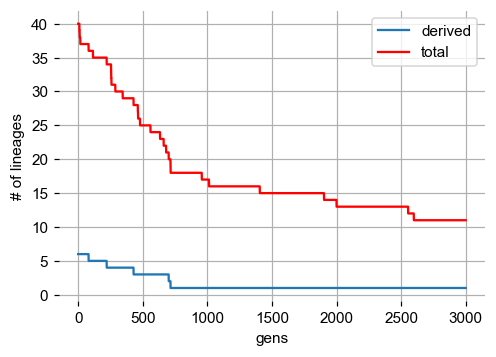

In [153]:
# haps = read_mssel('/Users/vivaswatshastry/selCoefEst/PReFerSims/msselfiles/hapfiles/haps-22.0_{:d}_t3000.ms'.format(48),40)[0]
# haps
plt.plot(haps[:,0],label='derived'); plt.plot(haps[:,1], label='total', color='red'); plt.ylabel('# of lineages'); plt.xlabel('gens'); plt.grid(); plt.box(False); plt.legend()

# tree = from_newick(str.split(open('/Users/vivaswatshastry/selCoefEst/PReFerSims/msselfiles/hapfiles/haps-22.0_48_t3000.ms').readlines()[5],'\n')[0])
# tree.draw_svg(size=(1000,800),y_axis=True,time_scale='log_time')

In [27]:
def python2round(f):
    if round(f + 1) - round(f) != 1:
        return f + abs(f) / f * 0.5
    return round(f)

def index_bis(i, n):
    return int(min(max(python2round(i * n / float(n+1)), 2), n-2))

def calcJK13(n):
    J = np.zeros((n,n-1))
    for i in range(n):
        ibis = index_bis(i + 1, n) - 1
        J[i, ibis] = -(1.+n) * ((2.+i)*(2.+n)*(-6.-n+(i+1.)*(3.+n))-2.*(4.+n)*(-1.+(i+1.)*(2.+n))*(ibis+1.)+(12.+7.*n+n**2)*(ibis+1.)**2) / (2.+n) / (3.+n) / (4.+n)
        J[i, ibis - 1] = (1.+n) * (4.+(1.+i)**2*(6.+5.*n+n**2)-(i+1.)*(14.+9.*n+n**2)-(4.+n)*(-5.-n+2.*(i+1.)*(2.+n))*(ibis+1.)+(12.+7.*n+n**2)*(ibis+1.)**2) / (2.+n) / (3.+n) / (4.+n) / 2.
        J[i, ibis + 1] = (1.+n) * ((2.+i)*(2.+n)*(-2.+(i+1.)*(3.+n))-(4.+n)*(1.+n+2.*(i+1.)*(2.+n))*(ibis+1.)+(12.+7.*n+n**2)*(ibis+1.)**2) / (2.+n) / (3.+n) / (4.+n) / 2.
    return J

def calcJK23(n):
    J = np.zeros((n + 1, n - 1))
    for i in range(n + 1):
        ibis = index_bis(i + 1, n) - 1
        if i == n - 1 or i == n:
            ibis = n - 3
        J[i, ibis] = -(1.+n) * ((2.+i)*(2.+n)*(-9.-n+(i+1.)*(3.+n))-2.*(5.+n)*(-2.+(i+1.)*(2.+n))*(ibis+1.)+(20.+9.*n+n**2)*(ibis+1.)**2) / (3.+n) / (4.+n) / (5.+n)
        J[i, ibis - 1] = (1.+n) * (12.+(1.+i)**2*(6.+5.*n+n**2)-(i+1.)*(22.+13.*n+n**2)-(5.+n)*(-8.-n+2.*(i+1.)*(2.+n))*(ibis+1.)+(20.+9.*n+n**2)*(ibis+1.)**2) / (3.+n) / (4.+n) / (5.+n) / 2.
        J[i, ibis + 1] = (1.+n) * ((2.+i)*(2.+n)*(-4.+(i+1.)*(3.+n))-(5.+n)*(n+2.*(i+1.)*(2.+n))*(ibis+1.)+(20.+9.*n+n**2)*(ibis+1.)**2) / (3.+n) / (4.+n) / (5.+n) / 2.
    return J

In [642]:
def calcnewD(m, n, it, kt):
    # has to be of size (m+n+1) x (m+n+1), can take values from 0...m+n (but mask 0 & m+n)
    data = []
    row = []
    col = []

    mpn = m + n
    
    for j in range(mpn - kt - it + 1):
        if j >= 0 and j <= mpn - kt:
            data.append(
                -(it * (mpn - kt - j) 
                  + j * (kt - it) 
                  + 2*j * (mpn - kt -j)
                 )
            )
            row.append(j + it)
            col.append(j + it)
        if j > 0:
            data.append(
                it * (mpn - kt - (j - 1)) 
                + (j-1) * (mpn - kt - (j - 1))
            )
            row.append(j + it)
            col.append(j - 1 + it)
        if j < mpn - kt:
            data.append(
                (j+1) * (mpn - it - (j+1))
            )
            row.append(j + it)
            col.append(j + 1 + it)

    return coo_matrix((data, (row, col)), shape=(mpn + 1, mpn + 1), dtype='float').tocsc()

In [643]:
def calcnewDcoal(m, n, it, kt, coal):
    data = []
    row = []
    col = []

    mpn = m + n

    if coal == 'der':
        for j in range(mpn - kt - it + 1):
            data += [(it - 1) * (mpn - kt - j), (it - 1) * (j + 1)]
            row += [j + it, j + it]
            col += [j + it - 1, j + it]
    elif coal == 'anc':
        for j in range(mpn - kt - it + 1):
            data += [(kt - it) * (j + 1), (kt - it) * (mpn - kt - j)]
            row += [j + it, j + it]
            col += [j + it + 1, j + it]
    
    return coo_matrix((data, (row, col)), shape=(mpn + 1, mpn + 1), dtype='float').tocsc()

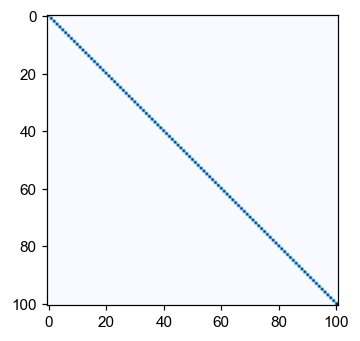

In [691]:
# Dc = calcnewDcoal(60, 40, haps[-2920,0], haps[-2920,1], 'der')
# plt.imshow(Dc.todense(), cmap='Blues'); plt.colorbar()
plt.imshow(Q.todense(), cmap='Blues')
# slv = linalg.factorized(sp.sparse.identity(101, dtype="float", format="csc") - 0.5 * 0.25/10000 * Dc)
# Q = sp.sparse.identity(101, dtype="float", format="csc") + 0.5 * 0.25/10000 * Dc
# slv(Q.dot(mom[2918,])), mom[2919,], Dc @ mom[2918,]
# %timeit Dc.dot(mom[2918,])
# Dc @ np.reshape([1]*101, (-1,1))
# 0.25/10000 * Dc @ mom[-2921,], mom[-2922,]

In [644]:
def calcnewS(m, n, it, kt, h=0.5):
    data = []
    row = []
    col = []

    mpn = m + n

    # keep in mind: ljk contains an extra factor of (m+n+1)
    for j in range(mpn - kt - it + 1): 
        data += [h * (j+1) * (3*j + 2*kt - 2*mpn),
                (mpn - kt - j + 1) * (3*j + kt - mpn) + h * it * (j+1) * (2*mpn - 2*kt - 2*j + 1) + 2*h * (j+1) * (kt-it) * (mpn - kt - j + 1),
                h * (mpn - kt - j + 1) * (mpn - kt - 3*j) + kt * (mpn - kt - j + 2) * (mpn - kt - j + 2)]
        row += 3 * [j + it]
        col += [j + 2 + it, j + 1 + it, j + it]

    # changing the size to be (m+n+2) x (m+n+2)
    return coo_matrix((data, (row, col)), shape=(mpn + 1, mpn + 3), dtype='float').tocsc()

In [1132]:
# s = 1e-4; N = 10000; m = 100; n = haps[-1,1]; h = 0.5
# mom = np.zeros((len(haps), 101))
# mom[0,haps[-1,0]] = 1
# plt.imshow(calcnewD(60, 40, haps[-1,0], haps[-1,1]).todense(), cmap='Blues'); plt.colorbar()
# D = calcnewD(60, 40, 1, 5)
# S = calcSnew(60, 40, 5, 35)
# J = sp.sparse.csc_matrix(calcJK23(102))

<101x101 sparse matrix of type '<class 'numpy.float64'>'
	with 9222 stored elements in Compressed Sparse Column format>

In [1025]:
def evolveSFSnos(N, haps, m=60):
    n = haps[0,1]
    mom = np.zeros((len(haps), m+n+1))
    mom[0,haps[-1,0]] = 1

    D = 0.25/N * calcnewD(m, n, haps[-1,0], haps[-1,1])
    slv = linalg.factorized(sp.sparse.identity(m + n + 1, dtype="float", format="csc") - 0.5 * D)
    Q = sp.sparse.identity(m + n + 1, dtype="float", format="csc") + 0.5 * D
    
    # starting from the past and moving to the present
    # so haps[-1,] is T^{th} generation in the past 
    for t in range(2,len(haps)+1):
        # no coalescent event 
        if haps[-t,1] == haps[-t+1,1]:
            # mom[t-1,] = 0.25/N * D.dot(mom[t-2,])
            mom[t-1,] = slv(Q.dot(mom[t-2,]))
            mom[t-1,0] = 0; mom[t-1,-1] = 0
        else:
            if haps[-t,0] > haps[-t+1,0]:
                Dc = 0.25/N * calcnewDcoal(m, n, haps[-t,0], haps[-t,1], 'der')
            elif haps[-t,0] == haps[-t+1,0]:
                Dc = 0.25/N * calcnewDcoal(m, n, haps[-t,0], haps[-t,1], 'anc')
            
            # slv = linalg.factorized(sp.sparse.identity(m + n + 1, dtype="float", format="csc") - 0.5 * Dc)
            # Q = sp.sparse.identity(m + n + 1, dtype="float", format="csc") + 0.5 * Dc
            # mom[t-1,] = slv(Q.dot(mom[t-2,]))

            diag = np.ones(m + n + 1); diag[:haps[-t,0]] = 0; diag[(m + n - haps[-t,1] + 1):] = 0
            Ic = sp.sparse.diags(diag, format="csc")
            mom[t-1,] = (Ic + Dc) @ mom[t-2,]
            # mom[t-1,0] = 0; mom[t-1,-1] = 0

            D = 0.25/N * calcnewD(m, n, haps[-t,0], haps[-t,1])
            slv = linalg.factorized(sp.sparse.identity(m + n + 1, dtype="float", format="csc") - 0.5 * D)
            Q = sp.sparse.identity(m + n + 1, dtype="float", format="csc") + 0.5 * D

    return mom[::-1]

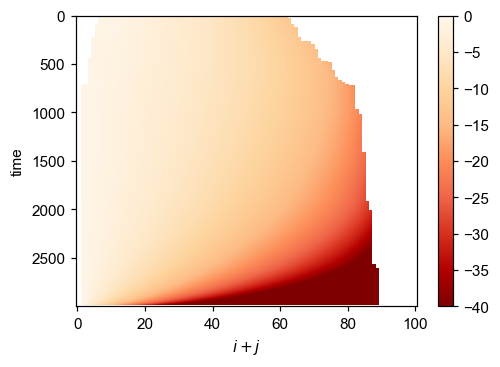

In [1274]:
mom = evolveSFSnos(10000, haps)
plt.imshow(np.log10(mom), cmap='OrRd_r', aspect='auto', vmin=-40); plt.xlabel(r'$i+j$'); plt.ylabel('time'); plt.colorbar(); plt.show()

# momold = run_mom_iterate_constant(len(haps), 40, 0, 10000, 1)
# plt.imshow(np.log10(momold), cmap='OrRd', aspect='auto', vmin=-6, vmax=0); plt.xlabel(r'$n$'); plt.ylabel('time'); plt.colorbar()

In [1286]:
# mom[-200,]
# Dc = 0.25 / 10000 * calcnewDcoal(60, 40, haps[-402,0], haps[-402,1], 'anc')
# Dc @ np.ones(101).reshape(-1,1)
# plt.imshow(Dc.todense(),aspect='auto'); plt.colorbar()
# haps[-2920,], haps[-2919,]
# haps[-403,], haps[-402,]
# SJ = S @J 
# %time sp.sparse.linalg.expm(400 *(D+SJ))
# np.sum(SJ.todense(),axis=1), np.sum(calcS(11, calcJK13(10)).todense(),axis=1)

(matrix([[154217.976],
         [151913.229],
         [149608.481],
         [147303.733],
         [144998.986],
         [142694.238],
         [140389.490],
         [138084.743],
         [135779.995],
         [133475.248],
         [131170.500],
         [128865.752],
         [126561.005],
         [124256.257],
         [121951.510],
         [119646.762],
         [117342.014],
         [115037.267],
         [112732.519],
         [110427.771],
         [108123.024],
         [105818.276],
         [103513.529],
         [101208.781],
         [98904.033],
         [96599.286],
         [94294.538],
         [91989.790],
         [89685.043],
         [87380.295],
         [85075.548],
         [82770.800],
         [80466.052],
         [78161.305],
         [75856.557],
         [73551.810],
         [71247.062],
         [68942.314],
         [66637.567],
         [64332.819],
         [62028.071],
         [59723.324],
         [57418.576],
         [55113.829],
        

In [1268]:
def evolveSFS(s, N, haps, h=0.5, m=60):
    n = haps[0,1]
    mom = np.zeros((len(haps), m + n + 1))
    mom[0, haps[-1,0]] = 1

    D = 0.25 / N * calcnewD(m, n, haps[-1,0], haps[-1,1])

    J = sp.sparse.csc_matrix(calcJK23(m + n + 2))
    S = s / ((m + n + 2) * (m + n + 1)) * calcnewS(m, n, haps[-1,0], haps[-1,1], h) @ J
    
    slv = linalg.factorized(sp.sparse.identity(m + n + 1, dtype="float", format="csc") - 0.5 * (D + S))
    Q = sp.sparse.identity(m + n + 1, dtype="float", format="csc") + 0.5 * (D + S)

    for t in range(2,len(haps)+1):
        # no coalescent event 
        if haps[-t,1] == haps[-t+1,1]:
            # mom[t-1,] = 0.25/N * D.dot(mom[t-2,])
            mom[t-1,] = slv(Q.dot(mom[t-2,]))
            mom[t-1,0] = 0; mom[t-1,-1] = 0
        else:
            if haps[-t,0] > haps[-t+1,0]:
                Dc = 0.25/N * calcnewDcoal(m, n, haps[-t,0], haps[-t,1], 'der')
            elif haps[-t,0] == haps[-t+1,0]:
                Dc = 0.25/N * calcnewDcoal(m, n, haps[-t,0], haps[-t,1], 'anc')

            diag = np.ones(m + n + 1); diag[:haps[-t,0]] = 0; diag[(m + n - haps[-t,1] + 1):] = 0
            Ic = sp.sparse.diags(diag, format="csc")
            
            ## adding a small perturbation to reduce condition number (still SUPER high tho)
            ## but caveat is that the indexing is throw astray
            # slv = linalg.factorized(Ic - 0.5 * Dc + 1e-3 * sp.sparse.identity(m + n + 1, format='csc'))
            # Q = Ic + 0.5 * Dc + 1e-3 * sp.sparse.identity(m + n + 1, format='csc')
            # mom[t-1,] = slv(Q.dot(mom[t-2,]))

            ## using the pseudo-inverse method
            ## produces quite a few NaNs but works ok
            # slv = np.linalg.pinv((Ic + 0.5 * Dc).todense())
            # Q = Ic - 0.5 * Dc
            # mom[t-1,] = slv @ Q @ mom[t-2,]
            
            ## using the midpoint method
            ## produces only NaNs
            # slv = Ic - 0.5 * Dc
            # Q = mom[t-2,] + 0.5 * Dc @ mom[t-2,]
            # mom[t-1,] = sp.sparse.linalg.spsolve(slv, Q)

            ## using Tikhonov regularization
            ## works the best but slowish 
            # slv = Ic - 0.5 * Dc
            # Q = Ic + 0.5 * Dc
            # A = slv + 1e-6 * sp.sparse.identity(slv.shape[1], format='csc')
            # b = Q @ mom[t-2,]
            # mom[t-1,] = sp.sparse.linalg.spsolve(A, b)
            # mom[t-1,0] = 0; mom[t-1,-1] = 0

            ## similar to approach 2 AND correctly indexes
            mom[t-1,] = (Ic + Dc) @ mom[t-2,]
            mom[t-1,0] = 0; mom[t-1,-1] = 0

            D = 0.25 / N * calcnewD(m, n, haps[-t,0], haps[-t,1])
            S = s / ((m + n + 2) * (m + n + 1)) * calcnewS(m, n, haps[-t,0], haps[-t,1], h) @ J
            slv = linalg.factorized(sp.sparse.identity(m + n + 1, dtype="float", format="csc") - 0.5 * (D + S))
            Q = sp.sparse.identity(m + n + 1, dtype="float", format="csc") + 0.5 * (D + S)

    return mom[::-1]

In [1214]:
def evolveSFS_expm(s, N, haps, h=0.5, m=60):
    n = haps[0,1]
    
    D = 0.25 / N * calcnewD(m, n, haps[-1,0], haps[-1,1])

    J = sp.sparse.csc_matrix(calcJK23(m + n + 2))
    S = s / ((m + n + 2) * (m + n + 1)) * calcnewS(m, n, haps[-1,0], haps[-1,1], h) @ J

    changepoints = len(haps)-np.concatenate((np.array([0]),np.where(haps[:-1,1] != haps[1:,1])[0]),axis=0)  
    changepoints = changepoints[::-1]
    
    mom = np.zeros((len(changepoints), m + n + 1))
    mom[0, haps[-1,0]] = 1
    mom[1,] = sp.sparse.linalg.expm(changepoints[0] * (D + S)) @ mom[0,]
    
    for i, _ in enumerate(changepoints[1:-1]):
        if haps[-changepoints[i],0] > haps[-changepoints[i]+1,0]:
            Dc = 0.25/N * calcnewDcoal(m, n, haps[-changepoints[i],0], haps[-changepoints[i],1], 'der')
        elif haps[-changepoints[i],0] == haps[-changepoints[i]+1,0]:
            Dc = 0.25/N * calcnewDcoal(m, n, haps[-changepoints[i],0], haps[-changepoints[i],1], 'anc')

        diag = np.ones(m + n + 1); diag[:haps[-changepoints[i],0]] = 0; diag[(m + n - haps[-changepoints[i],1] + 1):] = 0
        Ic = sp.sparse.diags(diag, format="csc") 
        mom[i+1,] = (Ic + Dc) @ mom[i+1,]
        
        D = 0.25 / N * calcnewD(m, n, haps[-changepoints[i],0], haps[-changepoints[i],1])

        J = sp.sparse.csc_matrix(calcJK23(m + n + 2))
        S = s / ((m + n + 2) * (m + n + 1)) * calcnewS(m, n, haps[-changepoints[i],0], haps[-changepoints[i],1], h) @ J
        mom[i+2,] = sp.sparse.linalg.expm((changepoints[i+1] - changepoints[i]) * (D + S)) @ mom[i+1,]

    return mom[::-1]

In [1168]:
# diag = np.ones(101); diag[:1] = 0; diag[(100-12+1):] = 0
# Ic = sp.sparse.diags(diag, format="csc")
# Dc = 0.25/10000 * calcnewDcoal(60, 40, 1, 12, 'anc')
# slv = linalg.factorized(Ic - 0.5 * Dc)
# np.linalg.pinv((Ic + 0.5 * Dc).todense())
# Q = Ic + 0.5 * Dc
# Q = Ic + 0.5 * Dc
# slv(Q.dot(np.ones(101)))
# linalg.factorized(sp.sparse.identity(101)-0.5*Dc)((Ic+0.5*Dc).dot(mom[100,]))
# Ic[:5,:5] = 0
# changepoints = len(haps)-np.concatenate((np.array([0]),np.where(haps[:-1,1] != haps[1:,1])[0],np.array([len(haps)-1])),axis=0)  
# changepoints[::-1]

<101x101 sparse matrix of type '<class 'numpy.float64'>'
	with 4017 stored elements in Compressed Sparse Column format>

CPU times: user 527 ms, sys: 4.89 ms, total: 532 ms
Wall time: 533 ms


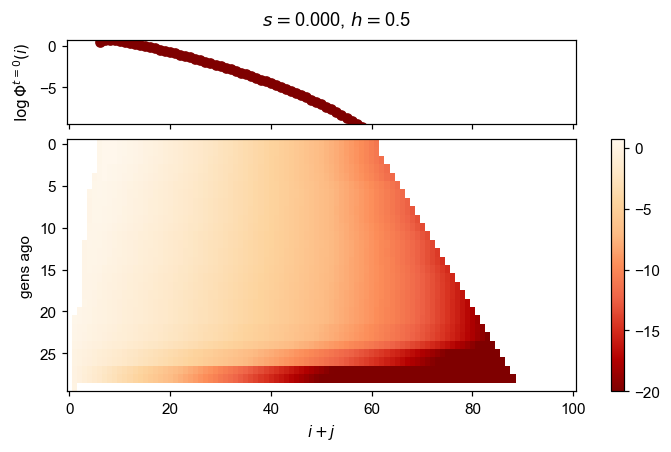

In [1264]:
s = 0.0001
%time mom = evolveSFS_expm(s, 10000, haps)
fig, (ax1, ax2) = plt.subplots(2, sharex=True, gridspec_kw={'height_ratios': [1, 3]}, constrained_layout=True, figsize=(6,4))
fig.suptitle(r'$s=${:.3f}, $h=${:.1f}'.format(s,h)); 
ax1.plot(np.log10(mom[0,]), '-o', color=plt.get_cmap('OrRd',lut=3)(2)); ax1.set_ylabel(r'$\log \Phi^{t=0}(i)$'); ax1.set_ylim((np.nanmax(np.log10(mom[0,]))-10,np.nanmax(np.log10(mom[0,]))))
im = ax2.imshow(np.log10(mom), cmap='OrRd_r', aspect='auto', vmin=-20); ax2.set_xlabel(r'$i+j$'); ax2.set_ylabel('gens ago'); fig.colorbar(im, ax=ax2)

In [1232]:
np.sum(np.log10(mom[0,6:61]/np.max(mom[0,6:61])))

-225.02253179491836

CPU times: user 148 ms, sys: 9.38 ms, total: 158 ms
Wall time: 206 ms


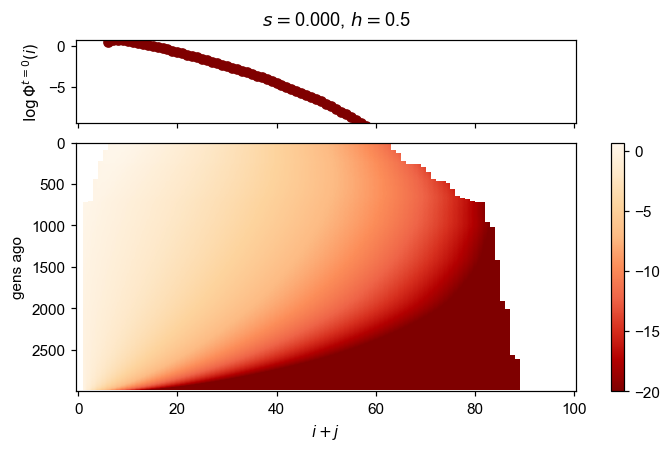

In [1269]:
s = 0.0001; h = 0.5
%time mom = evolveSFS(s, 10000, haps, h=h)
fig, (ax1, ax2) = plt.subplots(2, sharex=True, gridspec_kw={'height_ratios': [1, 3]}, constrained_layout=True, figsize=(6,4))
fig.suptitle(r'$s=${:.3f}, $h=${:.1f}'.format(s,h)); 
ax1.plot(np.log10(mom[0,]), '-o', color=plt.get_cmap('OrRd',lut=3)(2)); ax1.set_ylabel(r'$\log \Phi^{t=0}(i)$'); ax1.set_ylim((np.nanmax(np.log10(mom[0,]))-10,np.nanmax(np.log10(mom[0,]))))
im = ax2.imshow(np.log10(mom), cmap='OrRd_r', aspect='auto', vmin=-20); ax2.set_xlabel(r'$i+j$'); ax2.set_ylabel('gens ago'); fig.colorbar(im, ax=ax2)

# momold = run_mom_iterate_constant(len(haps), 100, 1e-6, 10000, 1)
# plt.imshow(np.log10(momold), cmap='OrRd', aspect='auto', vmin=-6, vmax=0); plt.xlabel(r'$n$'); plt.ylabel('time'); plt.colorbar()

Text(0, 0.5, '$\\sum_i \\Phi^t(i)$')

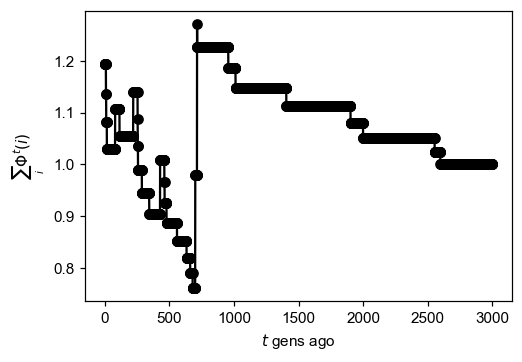

In [1275]:
# momproj = moments.Spectrum(mom[0,]).project([40])
# np.dot(np.arange(1,40),momproj.data[1:40]/np.sum(momproj.data[1:40]))
# ?sp.linalg.expm
# np.sum(np.log10(mom[0,6:61]/np.max(mom[0,6:61])))mom
plt.plot(mom.sum(axis=1),'-ko'); plt.xlabel(r'$t$ gens ago'); plt.ylabel(r'$\sum_i \Phi^t(i)$')
# plt.plot(mom[70,])

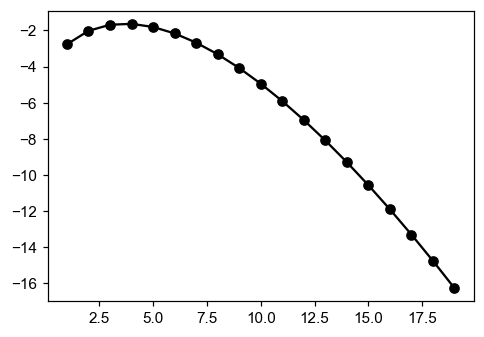

In [683]:
plt.plot(range(1,20),[sp.stats.poisson.logpmf(i,np.dot(np.arange(1,40),momproj.data[1:40]/np.sum(momproj.data[1:40]))) for i in range(1,20)],'-ok')